In [2]:
# Basic Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scaling the Data
from sklearn.preprocessing import MinMaxScaler

# Deep Learning Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
data = pd.read_csv("oil data update.csv")
print(data.head())
print(data.shape)

         Date  Price
0  02-01-1986  25.56
1  03-01-1986  26.00
2  06-01-1986  26.53
3  07-01-1986  25.85
4  08-01-1986  25.87
(9345, 2)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9345 entries, 0 to 9344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9345 non-null   datetime64[ns]
 1   Price   9339 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 146.1 KB


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")
data = data.sort_values("Date")
data = data.reset_index(drop=True)

print(data.head())

        Date  Price
0 1986-01-02  25.56
1 1986-01-03  26.00
2 1986-01-06  26.53
3 1986-01-07  25.85
4 1986-01-08  25.87


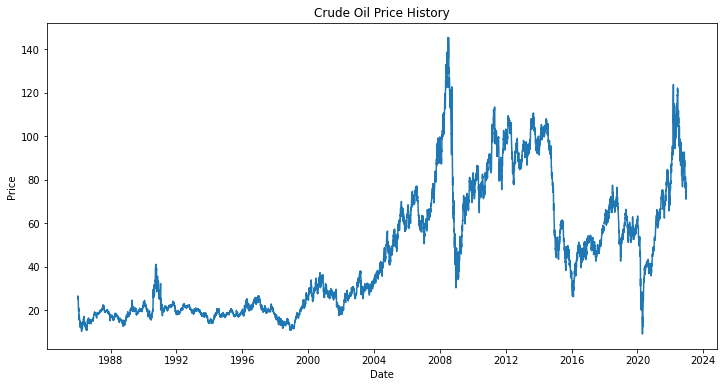

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Price'])
plt.title("Crude Oil Price History")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [6]:
# Extract only the Price column
price_data = data[['Price']]

# Apply MinMax Scaling (0 to 1 range)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

print("Scaled Data Shape:", scaled_data.shape)
print(scaled_data[:5])

Scaled Data Shape: (9345, 1)
[[0.12110092]
 [0.12433028]
 [0.12822018]
 [0.12322936]
 [0.12337615]]


In [7]:
X = []
y = []

# Use last 60 days to predict the next day
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i])

# Convert to NumPy arrays
X, y = np.array(X), np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9285, 60, 1)
y shape: (9285, 1)


In [8]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)

Training Size: (7428, 60, 1)
Testing Size: (1857, 60, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM Model
model = Sequential()

# 1st LSTM Layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# 2nd LSTM Layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
233/233 [==============================] - 13s 42ms/step - loss: 0.0028 - val_loss: nan
Epoch 2/20
233/233 [==============================] - 9s 39ms/step - loss: 0.0011 - val_loss: nan
Epoch 3/20
233/233 [==============================] - 10s 43ms/step - loss: 0.0011 - val_loss: nan
Epoch 4/20
233/233 [==============================] - 10s 44ms/step - loss: 8.4857e-04 - val_loss: nan
Epoch 5/20
233/233 [==============================] - 10s 42ms/step - loss: 9.1757e-04 - val_loss: nan
Epoch 6/20
233/233 [==============================] - 10s 41ms/step - loss: 7.3636e-04 - val_loss: nan
Epoch 7/20
233/233 [==============================] - 9s 41ms/step - loss: 7.2066e-04 - val_loss: nan
Epoch 8/20
233/233 [==============================] - 10s 44ms/step - loss: 6.5926e-04 - val_loss: nan
Epoch 9/20
233/233 [==============================] - 11s 48ms/step - loss: 6.7865e-04 - val_loss: nan
Epoch 10/20
233/233 [==============================] - 11s 47ms/step - loss: 6.1273e-04

In [12]:
predicted_prices = model.predict(X_test)
print(predicted_prices[:5])

59/59 [==============================] - 1s 12ms/step
[[0.27754518]
 [0.27339458]
 [0.27161157]
 [0.26919317]
 [0.2660506 ]]


In [13]:
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

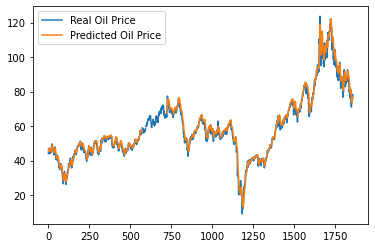

In [14]:
import matplotlib.pyplot as plt

plt.plot(real_prices, label="Real Oil Price")
plt.plot(predicted_prices, label="Predicted Oil Price")
plt.legend()
plt.show()

In [15]:
model.save("crude_oil_price_lstm_model.h5")
print("Model Saved Successfully!")

Model Saved Successfully!
